In [ ]:
!pip install xgboost
!pip install chemparse


Loading Dataset...
Loaded 255 rows.

🔵 PROCESS 1: Piezoelectric Coefficient (d33)
Starting feature engineering with Advanced Logic...
Feature engineering complete.

🔎 STARTING MODEL COMPARISON FOR: d33
------------------------------------------------------------
Model Name           | R2 Score   | RMSE      
------------------------------------------------------------
Random Forest        | 0.6079     | 69.7336
XGBoost              | 0.5805     | 72.1236
LightGBM             | 0.6290     | 67.8319
Gradient Boosting    | 0.6504     | 65.8411
SVM (SVR)            | 0.3185     | 91.9322


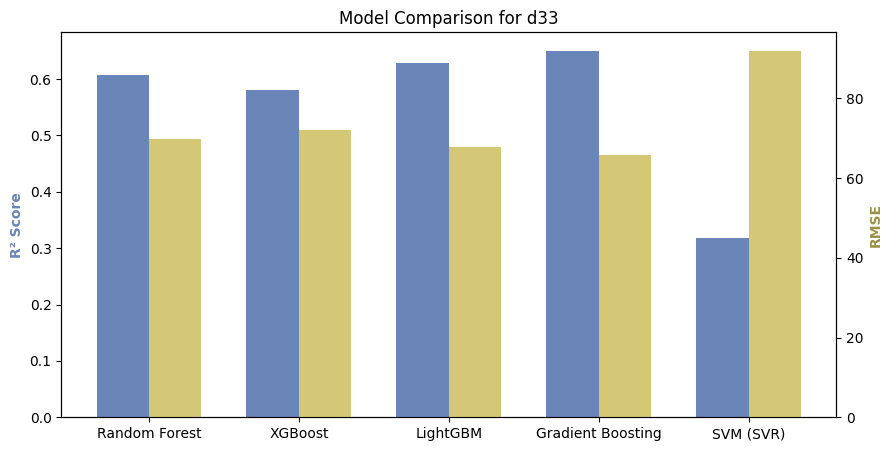

🏆 Winner for d33: Gradient Boosting
⚙️  Fine-Tuning Final Model for d33...
✅ Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

🔴 PROCESS 2: Curie Temperature (Tc)
Starting feature engineering with Advanced Logic...
Feature engineering complete.

🔎 STARTING MODEL COMPARISON FOR: Tc
------------------------------------------------------------
Model Name           | R2 Score   | RMSE      
------------------------------------------------------------
Random Forest        | 0.6932     | 45.1368
XGBoost              | 0.6173     | 50.4117
LightGBM             | 0.6157     | 50.5196
Gradient Boosting    | 0.6842     | 45.7925
SVM (SVR)            | 0.3951     | 63.3798


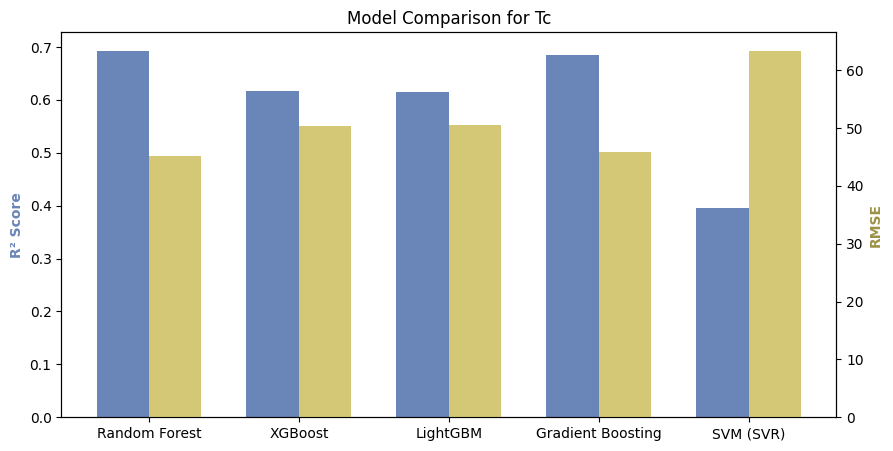

🏆 Winner for Tc: Random Forest
⚙️  Fine-Tuning Final Model for Tc...
✅ Best Params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

🚀 VIRTUAL LAB: INTERACTIVE PIEZOELECTRIC d33 & Tc PREDICTOR
Type 'exit' to quit.

💡 Input Examples:
   • 0.96(K0.48Na0.52)NbO3-0.04Bi0.5Na0.5TiO3
------------------------------------------------------------


In [ ]:
# =============================================================================
# UNIFIED ML PIPELINE: ROBUST PARSING -> COMPARISON -> PRODUCTION -> PREDICTION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import joblib
import os
import warnings
import re
import chemparse

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Suppress warnings
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
FORCE_RETRAIN = True  # Set True to see the comparison/tuning process every time
MODEL_DIR = "saved_models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

ALL_ELEMENTS = ['Ag', 'Al', 'B', 'Ba', 'Bi', 'C', 'Ca', 'Fe', 'Hf', 'Ho', 'K',
                'Li', 'Mn', 'Na', 'Nb', 'O', 'Pr', 'Sb', 'Sc', 'Sr', 'Ta', 'Ti',
                'Zn', 'Zr']

# =============================================================================
# 1. ADVANCED PARSING LOGIC (SINGLE SOURCE OF TRUTH)
# =============================================================================
def parse_formula(formula_str, valid_elements, verbose=False):
    """
    Parses complex solid solutions (e.g., 0.96(K0.5Na0.5)NbO3-0.04Bi0.5Na0.5TiO3).
    Handles coefficients, brackets, and mixing.
    """
    # 1. Initialize counters
    total_composition = {el: 0.0 for el in valid_elements}

    if not isinstance(formula_str, str):
        return total_composition

    # 2. Normalization (THE FIX IS HERE)
    # Remove spaces
    clean_str = formula_str.replace(" ", "")

    # Replace dots with hyphens ONLY if they are followed by an uppercase letter or open bracket.
    # This preserves decimals like "0.5" but splits "KNN.TiO3" or "KNN.(Bi...)"
    clean_str = re.sub(r'\.(?=[A-Z]|\()', '-', clean_str)

    # Split solid solutions by '-' or '+'
    parts = re.split(r'[\-\+]', clean_str)

    if verbose:
        print(f"\n   🔍 [Parser Audit] Analyzing: {formula_str}")

    for part in parts:
        if not part: continue

        # Extract leading coefficient (e.g., the 0.96 in 0.96(KNN))
        # The regex matches integers or decimals at the start
        coeff_match = re.match(r"^([\d\.]+)", part)

        if coeff_match:
            multiplier = float(coeff_match.group(1))
            # Remove the multiplier to parse the rest
            sub_formula = part[len(coeff_match.group(1)):]
        else:
            multiplier = 1.0
            sub_formula = part

        # Clean artifacts (like multiplication signs)
        sub_formula = sub_formula.lstrip("*")

        # Handle empty sub-formulas (e.g. if input was just a number "0.5")
        if not sub_formula:
            continue

        # Parse the chemical part
        try:
            part_composition = chemparse.parse_formula(sub_formula)
        except Exception:
            if verbose: print(f"      ⚠️ Failed to parse sub-part: {sub_formula}")
            continue

        # Add weighted atoms to total
        if part_composition:
            if verbose: print(f"      ‣ Found Part: {multiplier} x [{sub_formula}]")
            for el, amt in part_composition.items():
                # Clean element symbol (remove stray numbers if chemparse leaked any)
                el_clean = ''.join([i for i in el if not i.isdigit()])

                if el_clean in valid_elements:
                    added_amt = amt * multiplier
                    total_composition[el_clean] += added_amt
                elif verbose:
                     print(f"      ⚠️ Ignoring unknown element: {el}")

    return total_composition

def create_feature_matrix(formula_series, element_list):
    """
    Creates the training features using the SAME logic as the prediction loop.
    This ensures the model is trained on correctly parsed coefficients.
    """
    print("Starting feature engineering with Advanced Logic...")
    feature_data = []
    for formula in formula_series:
        # verbose=False to avoid spamming console during training
        composition_dict = parse_formula(str(formula), element_list, verbose=False)
        feature_data.append(composition_dict)

    df_features = pd.DataFrame(feature_data, columns=element_list)
    df_features = df_features.fillna(0.0)
    print("Feature engineering complete.")
    return df_features

# =============================================================================
# 2. HELPER FUNCTION: MODEL COMPARISON (PHASE 2 LOGIC)
# =============================================================================
def compare_models_and_visualize(X, y, property_name):
    print(f"\n🔎 STARTING MODEL COMPARISON FOR: {property_name}")
    print("-" * 60)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42),
        "LightGBM": lgb.LGBMRegressor(verbose=-1, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "SVM (SVR)": make_pipeline(StandardScaler(), SVR(C=100, epsilon=0.1))
    }

    results = []
    best_model_name = ""
    best_r2 = -float("inf")
    best_model_instance = None

    print(f"{'Model Name':<20} | {'R2 Score':<10} | {'RMSE':<10}")
    print("-" * 60)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append({"Model": name, "R2": r2, "RMSE": rmse})
        print(f"{name: <20} | {r2:.4f}     | {rmse:.4f}")

        if r2 > best_r2:
            best_r2 = r2
            best_model_name = name
            best_model_instance = model

    results_df = pd.DataFrame(results)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))
    x = np.arange(len(results_df["Model"]))
    width = 0.35
    ax1.bar(x - width/2, results_df["R2"], width, label='R²', color='#6A85B8')
    ax1.set_ylabel('R² Score', color='#6A85B8', fontweight='bold')
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, results_df["RMSE"], width, label='RMSE', color='#D4C876')
    ax2.set_ylabel('RMSE', color='#9C9246', fontweight='bold')
    plt.title(f'Model Comparison for {property_name}')
    plt.xticks(x, results_df["Model"])
    plt.show()

    print(f"🏆 Winner for {property_name}: {best_model_name}")
    return best_model_name

# =============================================================================
# 3. HELPER FUNCTION: PRODUCTION TRAINING (PHASE 3 LOGIC)
# =============================================================================
def train_production_model(X, y, target_name):
    model_path = os.path.join(MODEL_DIR, f"final_model_{target_name}.pkl")

    if os.path.exists(model_path) and not FORCE_RETRAIN:
        print(f"📂 Loading saved {target_name} model...")
        return joblib.load(model_path)

    print(f"⚙️  Fine-Tuning Final Model for {target_name}...")
    base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.6, 0.8]
    }

    search = RandomizedSearchCV(base_model, param_dist, n_iter=10, scoring='neg_root_mean_squared_error', cv=3, verbose=0, random_state=42)
    search.fit(X, y)

    best_model = search.best_estimator_
    joblib.dump(best_model, model_path)
    print(f"✅ Best Params: {search.best_params_}")
    return best_model

# =============================================================================
# 4. MAIN EXECUTION FLOW
# =============================================================================

print("\nLoading Dataset...")
try:
    df = pd.read_csv("dataset.csv")
    print(f"Loaded {len(df)} rows.")
except:
    print("❌ Dataset not found. Please upload 'dataset.csv'.")
    df = pd.DataFrame()

if not df.empty:
    target_cols = {'d33': 'd33 (pC/N)', 'Tc': 'Tc (C)'}

    # --- B. Process d33 ---
    print("\n" + "="*40)
    print("🔵 PROCESS 1: Piezoelectric Coefficient (d33)")
    print("="*40)

    if target_cols['d33'] in df.columns:
        df_d33 = df.dropna(subset=['Component', target_cols['d33']]).reset_index(drop=True)
        X_d33 = create_feature_matrix(df_d33['Component'], ALL_ELEMENTS)
        y_d33 = df_d33[target_cols['d33']]
        X_columns = X_d33.columns.tolist()

        compare_models_and_visualize(X_d33, y_d33, "d33")
        final_model_d33 = train_production_model(X_d33, y_d33, "d33")
    else:
        final_model_d33 = None

    # --- C. Process Tc ---
    print("\n" + "="*40)
    print("🔴 PROCESS 2: Curie Temperature (Tc)")
    print("="*40)

    tc_col_actual = None
    for col in df.columns:
        if 'Tc' in col or 'Curie' in col:
            tc_col_actual = col
            break

    if tc_col_actual:
        df_tc = df.dropna(subset=['Component', tc_col_actual]).reset_index(drop=True)
        if len(df_tc) > 10:
            X_tc = create_feature_matrix(df_tc['Component'], ALL_ELEMENTS)
            y_tc = df_tc[tc_col_actual]
            compare_models_and_visualize(X_tc, y_tc, "Tc")
            final_model_tc = train_production_model(X_tc, y_tc, "Tc")
        else:
            print("⚠️ Not enough Tc data.")
            final_model_tc = None
    else:
        print("⚠️ No Tc column found.")
        final_model_tc = None

    # =========================================================================
    # 5. INTERACTIVE PREDICTION LOOP
    # =========================================================================
    print("\n" + "="*60)
    print("🚀 VIRTUAL LAB: INTERACTIVE PIEZOELECTRIC d33 & Tc PREDICTOR")
    print("="*60)
    print("Type 'exit' to quit.\n")
    print("💡 Input Examples:")
    print("   • 0.96(K0.48Na0.52)NbO3-0.04Bi0.5Na0.5TiO3")
    print("-" * 60)

    def predict_properties(formula, model_d33, model_tc, cols):
        # 1. Strict Check
        found_symbols = set(re.findall(r"[A-Z][a-z]?", formula))
        valid_set = set(ALL_ELEMENTS)
        invalid = found_symbols - valid_set
        if invalid:
            raise ValueError(f"Formula contains invalid elements: {invalid}")

        # 2. Advanced Parsing (with verbose audit)
        composition_dict = parse_formula(formula, ALL_ELEMENTS, verbose=True)

        if sum(composition_dict.values()) == 0:
            raise ValueError("Formula parsed to empty. Check formatting.")

        # 3. Print Final Composition
        active_elements = {k: v for k, v in composition_dict.items() if v > 0}
        print(f"   ✅ [Final Composition] Used for Prediction:\n      {active_elements}")

        # 4. Predict
        input_df = pd.DataFrame([composition_dict])
        for c in cols:
            if c not in input_df.columns: input_df[c] = 0.0
        input_df = input_df[cols]

        val_d33 = model_d33.predict(input_df)[0] if model_d33 else None
        val_tc = model_tc.predict(input_df)[0] if model_tc else None
        return val_d33, val_tc

    while True:
        formula = input("\n🧪 Enter Formula (or 'exit'): ").strip()
        if formula.lower() in ['exit', 'quit']: break
        if not formula: continue

        try:
            if not any(char.isdigit() for char in formula):
                raise ValueError("Formula format incorrect. Missing numbers.")

            d33_pred, tc_pred = predict_properties(formula, final_model_d33, final_model_tc, X_columns)

            print("-" * 40)
            print(f"⚡ Predicted d33: {d33_pred:.2f} pC/N" if d33_pred else "⚡ d33: N/A")
            print(f"🔥 Predicted Tc:  {tc_pred:.2f} °C" if tc_pred else "🔥 Tc:  N/A")
            print("-" * 40)

        except ValueError as ve:
            print(f"⚠️  Input Error: {ve}")
        except Exception as e:
            print(f"❌ An unexpected error occurred: {e}")

else:
    print("Script finished (No data loaded).")